#### Preliminaries
<small>This section includes package imports and some utility functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.stats import spearmanr
from scipy.optimize import minimize
from numba import njit

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import os

if not os.path.exists('/content/E-PINN-Bergman'):
    !git clone https://github.com/HaiSiong-Tan/E-PINN.git
    
MODEL_DIR = '/content/E-PINN/EPINN_case_studies/models'

##### utility functions

In [3]:
class FCN(nn.Module):

    """
      Multilayer perceptron model, with outputs corresponding to targets of Deep Evidential Regression

      Args:
          N_INPUT : number of independent variables in the ODE
          N_HIDDEN : number of neurons per hidden layer
          N_LAYERS : number of hidden layers

      Returns:
          alpha, beta, nu, gamma : evidential deep learning-based outputs, with gamma being the mean and the
                                   rest related to the uncertainty

    """

    def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_alpha = nn.Linear(N_HIDDEN, 1)
        self.output_beta = nn.Linear(N_HIDDEN, 1)
        self.output_nu = nn.Linear(N_HIDDEN, 1)
        self.output_gamma = nn.Linear(N_HIDDEN, 1)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        softplus = nn.Softplus()
        alpha = 1.1 + softplus(self.output_alpha(x))
        beta = softplus(self.output_beta(x))
        nu = 2.0+softplus(self.output_nu(x))
        gamma = self.output_gamma(x)

        return alpha, beta, nu, gamma


def exact_wave(r,D):

    """
    Generates an exact solution to the Fisher-KPP equation; see eqn.21

    Args:
        r,D are the 'growth' and 'diffusion' rates.

    Returns:
        a 50 by 100 array representing the solution evaluated at each point of x in (-20,20), t in (0,10)

    """

    c = (5 / np.sqrt(6)) * np.sqrt(r * D)
    sqrt_term = np.sqrt(6 * D / r)
    x = np.linspace(-20, 20, 100)
    t = np.linspace(0, 10, 50)
    X, T = np.meshgrid(x, t)
    # Exact solution
    U = 1.0 / (1 + np.exp((X - c * T) / sqrt_term))**2
    return U



def evidential_data_loss(u_obs, gamma, nu, alpha, beta ):

    """
    Loss function of Evidential Deep Learning (EDL)

    Args:
        u_obs : observed target
        alpha, beta, nu, gamma : evidential model's outputs with 'gamma' being mean

    Returns:
        value of EDL loss -- this is the main loss term governing target prediction with uncertainty estimates.
    """

    twoBlambda = 2*(beta)*(1+nu)

    nll = 0.5*torch.log(torch.pi/(nu))  \
        - alpha*torch.log(twoBlambda)  \
        + (alpha+0.5) * torch.log(nu*(u_obs-gamma)**2 + twoBlambda)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return torch.mean(nll)



def CI_calculation(interval_CI, alpha, beta, nu, gamma):

    """
    Function that computes the confidence interval for the model's output

    Args:
        interval_CI : confidence interval, e.g. 0.95 for 95% interval
        alpha, beta, nu, gamma : evidential model's outputs with 'gamma' being mean

    Returns:
        lower bound of the confidence interval assuming mean centered at 0
    """
    from scipy.stats import t
    scale_sq = beta*(1+nu)/(alpha*nu)
    scale = np.sqrt(scale_sq)

    I_delta = []

    for i in range(len(alpha)):
      a,b= t.interval(interval_CI, df=2*alpha[i], loc=0, scale=scale[i])
      I_delta.append(a)

    return np.array(I_delta)



@njit
def F_njit_ind(r_0, D_0, u, grad2x_L, grad1t_L):

    """
    Computes residual loss for the Fisher-KPP equation (eqn. 20)

    Args:
    -----
      u: target/dependent variable
      r_0, D_0: parameters to be inferred
      grad2x_L: second derivative w.r.t. x
      grad1t_L: first derivative w.r.t. t

    Returns:
    --------
      the R^2_i function for the Fisher-KPP equation
    """

    resi_loss = (-grad1t_L + D_0*grad2x_L + r_0*u*(1-u) )**2

    return resi_loss



@njit
def compute_z_array(r_vec, D_vec, u, grad2x_L, grad1t_L):

    """
    Computes a R by D by len(u) array of PDE residuals for Fisher-KPP eqn., R = len(r_vec), D = len(D_vec)

    Args:
    -----
    u: target variable
    r_vec, D_vec: parameters to be inferred
    grad2x_L: second derivative w.r.t. x
    grad1t_L: first derivative w.r.t. t

    Returns:
    --------
    an array of shape (R,D,len(u)) of PDE residuals for each combination of r and D

    """

    I,J,M = len(r_vec),len(D_vec),len(u)
    Z = np.empty((I,J,M))
    for i in range(I):
      for j in range(J):
       Z[i,j,:]= F_njit_ind(r_vec[i], D_vec[j], u, grad2x_L, grad1t_L)
    return Z



@njit
def njit_marginal_ll(variance_R, resi_sum_array):

    """
    Computes the unnormalized likelihood function defined as the exponential of PDE residual

    Args:
        variance_R: variance parameter in the PDE residual (inverse of PDE residual loss weight)
        resi_sum_array: the PDE residual sum

    Returns:
        the unnormalized likelihood function

    """

    pdf_unnorm = np.exp(-1*((1/(2*variance_R))*resi_sum_array) )
    return pdf_unnorm



def kl_divergence_f(variance_array, resi_sum_array, p1_prior, p2_prior, epsilon ):

    """
    Computes the Kullback-Leibler divergence between the likelihood function and
    and the product of the prior functions for each unknown parameter.

    Args:
        variance_array: variance of the PDE likelihood function or the inverse of the loss weight for PDE residual
        resi_sum_array: the PDE residual (summed over all temporal points)
        p1_prior, p2_prior: prior density function for each parameter
        epsilon: regularization parameter

    Returns:
        KL divergence between the parameter prior and the likelihood function defined by
        the exponential of the PDE residual

    """

    q_vals = np.exp(-1*((1/(2*variance_array))*resi_sum_array) )
    Q_safe = q_vals/np.sum(q_vals)

    prior_pdf = (p1_prior[:, None] * p2_prior[None, :] )
    P_safe = prior_pdf/np.sum(prior_pdf)

    if epsilon > 0:
      Q_safe = np.clip(Q_safe, epsilon, 1.0)
      Q_safe = Q_safe / np.sum(Q_safe)
      P_safe = np.clip(P_safe, epsilon, 1.0)
      P_safe = P_safe / np.sum(P_safe)

    log_P_safe = np.log(P_safe)
    log_Q_safe = np.log(Q_safe)

    kl_div = np.sum(P_safe * (log_P_safe - log_Q_safe))

    return kl_div



### Dataset

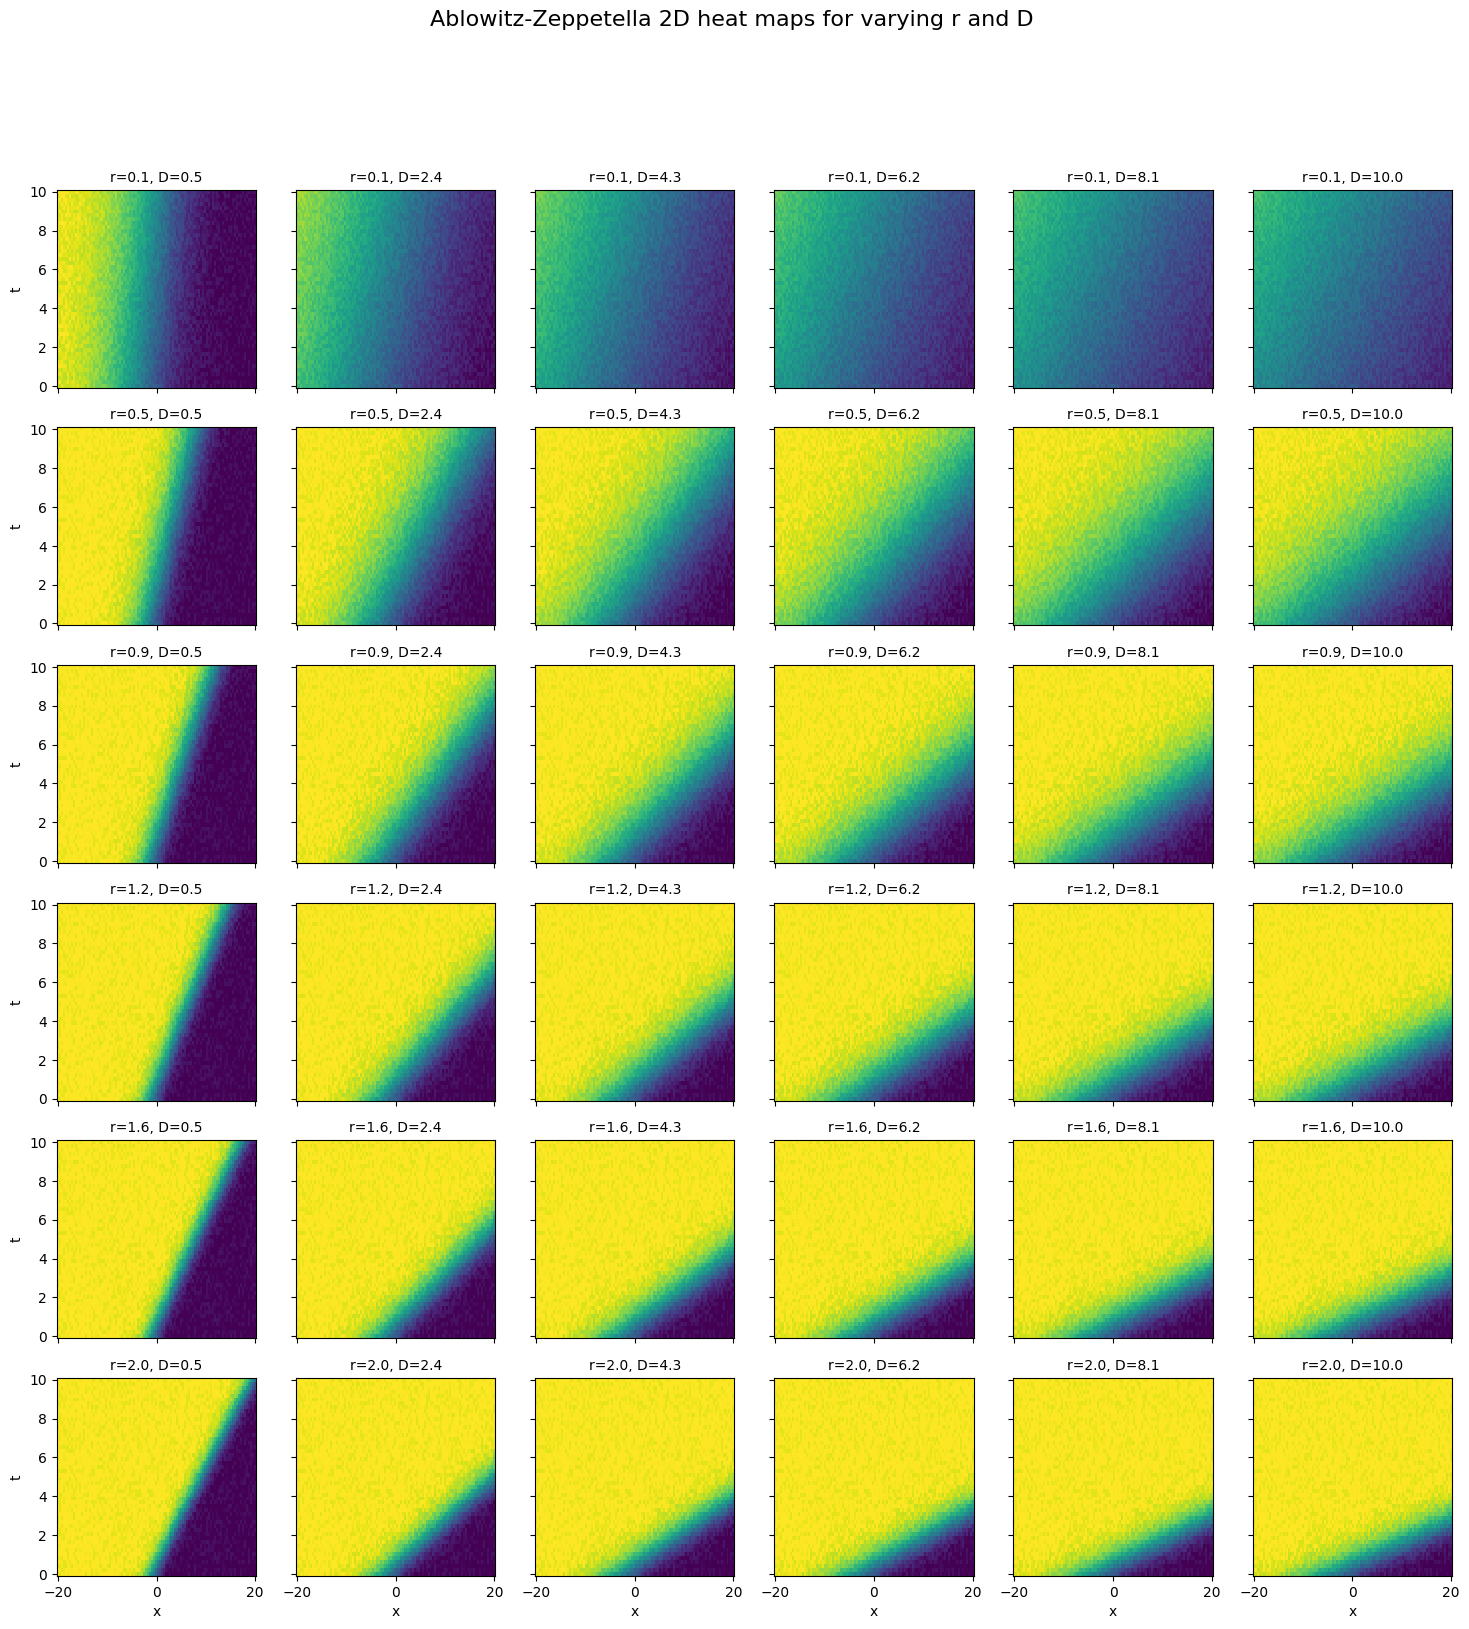

In [4]:
#Visualization of some exact solutions

# Parameter ranges
r_list = np.linspace(0.1, 2.0, 6)
D_list = np.linspace(0.5, 10, 6)

# Domains of spacetime coordinates
x = np.linspace(-20, 20, 100)
t = np.linspace(0, 10, 50)
X, T = np.meshgrid(x, t)

# noise
np.random.seed(40)
noise = 0.1*(np.random.rand(50,100)-0.5)

# plotting
fig, axes = plt.subplots(6, 6, figsize=(18, 18), sharex=True, sharey=True)

for i, r in enumerate(r_list):
    for j, D in enumerate(D_list):
        ax = axes[i, j]

        # Compute wave speed and sqrt term
        c = (5 / np.sqrt(6)) * np.sqrt(r * D)
        sqrt_term = np.sqrt(6 * D / r)

        # Exact solution
        U = 1.0 / (1 + np.exp((X - c * T) / sqrt_term))**2
        U += noise

        # Plot heatmap
        im = ax.pcolormesh(X, T, U, shading='auto', cmap='viridis', vmin=0, vmax=1)

        ax.set_title(f"r={r:.1f}, D={D:.1f}", fontsize=10)
        if i == 5:
            ax.set_xlabel("x")
        if j == 0:
            ax.set_ylabel("t")

plt.suptitle("Ablowitz-Zeppetella 2D heat maps for varying r and D", fontsize=16)
plt.show()



In [5]:
# Generating synthetic dataset
x = np.linspace(-20, 20, 100)
t = np.linspace(0, 10, 50)
X, T = np.meshgrid(x, t)
XT = np.column_stack((X.ravel(), T.ravel()))

# Synthetic noise added to training data to test correlation between model's uncertainty prediction and noise
np.random.seed(137)
noise = 0.10*(np.random.rand(50,100)-0.5)

# Creating noiseless regions: remove noise for first and last 10 values of time
noise[:10,:] = 0
noise[-10:,:] = 0

# Adding random noise to U
U = exact_wave(1.6,6.2) + noise
U_flat = U.ravel()

XT = torch.tensor(XT, dtype=torch.float32)
U_flat = torch.tensor(U_flat, dtype=torch.float32)
U_flat = U_flat.view(-1, 1)

# Specifying CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
XT = XT.to(device)
U_flat = U_flat.to(device)

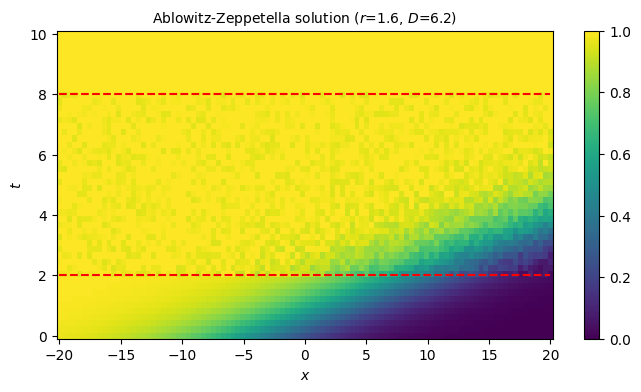

In [6]:
#Visualizing training data

U_reconstructed = U_flat.reshape(50, 100)

plt.figure(figsize=(8, 4))
pc = plt.pcolormesh(X, T, U_reconstructed.detach().cpu().numpy(), shading='auto', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(pc)
plt.title(r"Ablowitz-Zeppetella solution ($r$=1.6, $D$=6.2)", fontsize=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$t$")
plt.plot([-20,20],[2,2],'r--')
plt.plot([-20,20],[8,8],'r--')
plt.show()


In [7]:
x_residual = XT[:,0].reshape(-1,1)
t_residual = XT[:,1].reshape(-1,1)
x_residual = x_residual.requires_grad_()
t_residual = t_residual.requires_grad_()

### 1st training phase: data-fitting

In [ ]:
nn_I = FCN(2,16,2).to(device)

n_D = XT.shape[0]

lr = 3e-4

loss_list = []

optimizer = optim.Adam(list(nn_I.parameters()), lr=lr)

# Training loop
for epoch in range(200_001):

  optimizer.zero_grad()

  L_p_alpha, L_p_beta, L_p_nu, L_pred = nn_I(XT)

  #-----Data Loss-----------------------------------------

  data_loss = n_D*evidential_data_loss(L_pred, U_flat, L_p_nu, L_p_alpha, L_p_beta)

  #-----Total loss----------------------------------------
  loss = data_loss

  # Backpropagation
  loss.backward()
  optimizer.step()

  # Print loss every 1000 epochs
  if epoch % 1000 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():.3e}")
      loss_list.append(loss.item())

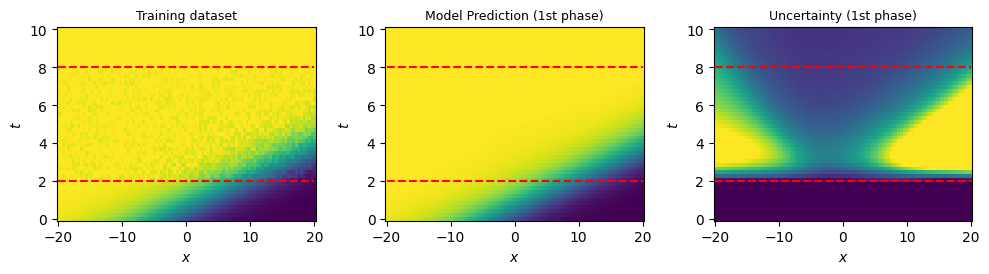

In [10]:
#saving and visualising initial model prediction

#torch.save(nn_I.state_dict(), f'{MODEL_DIR}/ini_epinn_fisher.pth')
#torch.save({
#    'loss_list': loss_list
#}, f'{MODEL_DIR}/ini_epinn_fisher_loss.pth')

nn_I = FCN(2,16,2).to(device)  # nn_I is our EDL model
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/ini_epinn_fisher.pth'))

Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(XT)

n_L_pred = np.squeeze(L_pred.detach().cpu().numpy())
n_Lp_alpha = np.squeeze(Lp_alpha.detach().cpu().numpy())
n_Lp_beta = np.squeeze(Lp_beta.detach().cpu().numpy())
n_Lp_nu = np.squeeze(Lp_nu.detach().cpu().numpy())

plot_L_pred = n_L_pred.reshape(50, 100)
plot_Lp_alpha = n_Lp_alpha.reshape(50, 100)
plot_Lp_beta = n_Lp_beta.reshape(50, 100)
plot_Lp_nu = n_Lp_nu.reshape(50, 100)

uncertainty = (1+ 1/plot_Lp_nu)*plot_Lp_beta/(plot_Lp_alpha-1)

U_reconstructed = U_flat.reshape(50, 100)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

pc = axes[0].pcolormesh(X, T, U_reconstructed.detach().cpu().numpy(), shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[0].set_title(r"Training dataset", fontsize=9)
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$t$")
axes[0].plot([-20,20],[2,2],'r--')
axes[0].plot([-20,20],[8,8],'r--')

pc = axes[1].pcolormesh(X, T, plot_L_pred, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[1].set_title(r"Model Prediction (1st phase)", fontsize=9)
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$t$")
axes[1].plot([-20,20],[2,2],'r--')
axes[1].plot([-20,20],[8,8],'r--')

pc = axes[2].pcolormesh(X, T, uncertainty.reshape(50,100), shading='auto', cmap='viridis', vmin = 0.00, vmax = 0.005)
axes[2].set_title(r"Uncertainty (1st phase)", fontsize=9)
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$t$")
axes[2].plot([-20,20],[2,2],'r--')
axes[2].plot([-20,20],[8,8],'r--')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Text(0.5, 1.0, 'Error Calibration Plot')

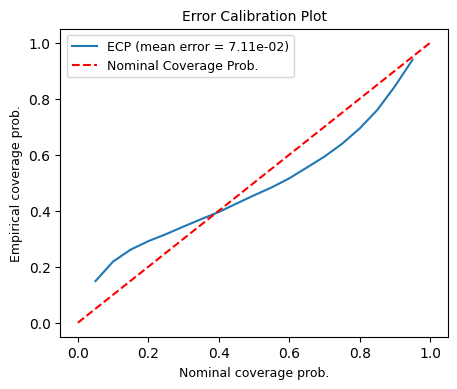

In [11]:
#Check empirical coverage probability for initial model

empirical_data = np.squeeze(U_flat).detach().cpu().numpy()

ecp_list = []
dis_list = []

for j in range(19):

  interval_CI = (j+1)*0.05

  neg_CI_delta = CI_calculation(interval_CI, n_Lp_alpha, n_Lp_beta ,
                                  n_Lp_nu, n_L_pred)

  acc=0
  for i in range(len(empirical_data)):
    if  np.abs(empirical_data[i] - n_L_pred[i])  < np.abs(neg_CI_delta[i]) :
      acc += 1

  empirical_ecp = acc/len(empirical_data)
  discrepancy = np.abs(empirical_ecp - interval_CI)

  dis_list.append(discrepancy)
  ecp_list.append(acc/len(empirical_data))

plt.figure(figsize=(5,4))
plt.plot(np.arange(0.05, 1.0, 0.05), ecp_list, label=f'ECP (mean error = {np.mean(dis_list):.2e})')
plt.plot([0,1],[0,1],'r--', label='Nominal Coverage Prob.')
plt.legend(fontsize = 9)
plt.xlabel('Nominal coverage prob.', fontsize=9)
plt.ylabel('Empirical coverage prob.', fontsize = 9)
plt.title('Error Calibration Plot', fontsize=10)


### Determining priors for 2nd training phase

In [12]:
# Parameter ranges
r_vals = np.linspace(0.1, 2.0, 50)
D_vals = np.linspace(0.5, 10, 50)

# coordinate domains
x = np.linspace(-20, 20, 100)
t = np.linspace(0, 10, 50)
X, T = np.meshgrid(x, t)

In [13]:
#Loading model
ini_nn_I = FCN(2,16,2).to(device)
ini_nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/ini_epinn_fisher.pth'))

<All keys matched successfully>

##### Prior for the parameters

In [14]:
msd_list = []

Lp_alpha, Lp_beta, Lp_nu, L_pred = ini_nn_I(XT)
L_monte_pred = L_pred.detach().cpu().numpy()

for r0 in r_vals:
  for D0 in D_vals:
    L_infer = exact_wave(r0, D0).flatten()
    msd = np.sum((np.squeeze(L_monte_pred) - L_infer)**2)
    msd_list.append(msd)

msd_var = np.mean(msd_list)

mse = np.exp(-0.5*np.array(msd_list)/msd_var)

prob_grid = mse.reshape(len(r_vals), len(D_vals))

row, col = np.unravel_index(np.argmax(mse), [50,50])

r_prior_mean = r_vals[row]
D_prior_mean = D_vals[col]

In [15]:
dr = r_vals[2] - r_vals[1]
dD = D_vals[2] - D_vals[1]

P1, P2 = np.meshgrid(D_vals, r_vals)

prob_grid /= (prob_grid.sum()*dr*dD)
r_marginal = np.sum(prob_grid, axis = 1)*dD
D_marginal = np.sum(prob_grid, axis = 0)*dr

r_cdf = np.zeros(len(r_vals))

norm_r = np.sum(r_marginal)*dr
for i in range(len(r_vals)):
  r_cdf[i] = np.sum(r_marginal[:i])*dr/norm_r

D_cdf = np.zeros(len(D_vals))

norm_D = np.sum(D_marginal)*dD
for i in range(len(D_vals)):
  D_cdf[i] = np.sum(D_marginal[:i])*dD/norm_D

Q1 = np.interp(0.25, r_cdf, r_vals)
Q3 = np.interp(0.75, r_cdf, r_vals)
r_std = (Q3 - Q1)/1.349

Q1 = np.interp(0.25, D_cdf, D_vals)
Q3 = np.interp(0.75, D_cdf, D_vals)
D_std = (Q3 - Q1)/1.349

r_prior = (1/np.sqrt(2*3.14*r_std**2))*np.exp(-1*(1/(2*r_std**2))*(r_vals - r_prior_mean)**2)
D_prior = (1/np.sqrt(2*3.14*D_std**2))*np.exp(-1*(1/(2*D_std**2))*(D_vals - D_prior_mean)**2)

Text(0.5, 1.0, 'Prior distribution $\\pi(\\vec{\\Omega})$ [2D Fisher-KPP]')

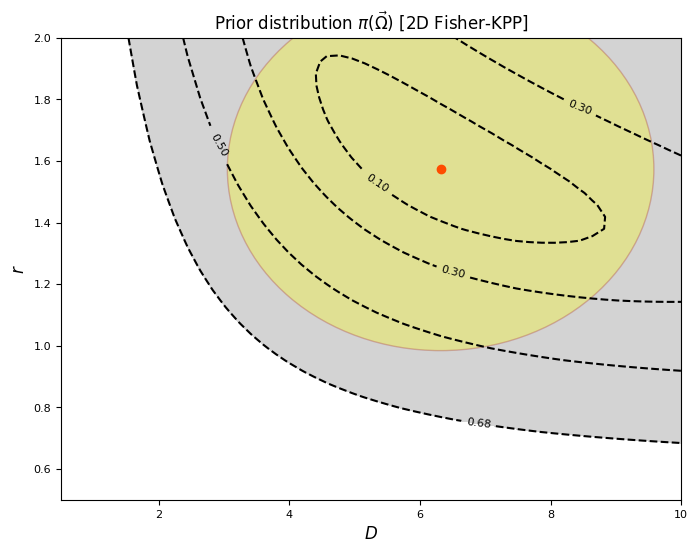

In [16]:
#Visualizing the parameter prior distribution overlaid on the Highest Density Region of eqn.9

from matplotlib.patches import Ellipse

prob_flat = prob_grid.ravel()
pdf_sorted = np.sort(prob_flat)[::-1]
cumsum = np.cumsum(pdf_sorted)*dr*dD

level_value_list = []
level_list = [0.68, 0.5, 0.3, 0.1]
for level in level_list:
  level_idx = np.where(cumsum >= level)[0][0]
  level_value_list.append(pdf_sorted[level_idx])

label_dict = {lv: f"{cl:.2f}" for lv, cl in zip(level_value_list, level_list)}

# Contour plot of HDR and the parameter prior distribution
plt.figure(figsize=(8, 6))
cs = plt.contour(P1, P2, prob_grid, levels=level_value_list, colors='black', linestyles='dashed')
plt.contourf(P1, P2, prob_grid, levels=[level_value_list[0], prob_grid.max()], colors=['lightgray'])
plt.scatter(D_vals[col],r_vals[row], color ='r')
plt.clabel(cs, inline=True, fmt=label_dict, fontsize=8)

# Overlaying parameter prior distribution
eclipse = Ellipse((D_vals[col], r_vals[row]), width=2*D_std, height=2*r_std, angle=0,
                  edgecolor='brown', facecolor='yellow', linewidth=1, alpha = 0.3)

ax = plt.gca()
ax.add_patch(eclipse)
ax.set_xlim(0.5, 10)
ax.set_ylim(0.5, 2.0)
ax.tick_params(axis='both', labelsize=8)
plt.title("Fisher-KPP", fontsize=10)
plt.xlabel(r'$D$',fontsize=12)
plt.ylabel(r'$r$',fontsize=12)
plt.title(r'Prior distribution $\pi(\vec{\Omega})$ [2D Fisher-KPP]')


##### Prior for the ODE residual's loss weight $\sigma^2_R$

In [17]:
initial_L_alpha, initial_L_beta, initial_L_nu, initial_L_pred = ini_nn_I(torch.cat((x_residual, t_residual), dim=1))

initial_dL_dx = torch.autograd.grad(initial_L_pred, x_residual,
                                  grad_outputs=torch.ones_like(initial_L_pred), create_graph=True)[0]

initial_grad2x_L = torch.autograd.grad(initial_dL_dx, x_residual,
                                  grad_outputs=torch.ones_like(initial_L_pred), create_graph=True)[0]

initial_dL_dt = torch.autograd.grad(initial_L_pred, t_residual,
                                  grad_outputs=torch.ones_like(initial_L_pred), create_graph=True)[0]

#----converting to numpy objects for computing residual sum --------------------------------
njit_initial_L_pred = np.squeeze(initial_L_pred.detach().cpu().numpy())
njit_initial_grad2x_L = np.squeeze(initial_grad2x_L.detach().cpu().numpy())
njit_initial_dL_dt = np.squeeze(initial_dL_dt.detach().cpu().numpy())

resi_sum = compute_z_array(r_vals, D_vals, njit_initial_L_pred, njit_initial_grad2x_L, njit_initial_dL_dt )

# Initial Likelihood Function (PDE residual) ------------------------------------------------
resi_sum_array = np.sum(resi_sum, axis = -1)



In [18]:
# Minimizing KL divergence between parameter prior and initial likelihood to determine initial $\sigma^2_R$ (eqn. 14)

def objective(variance_array):
    vari = variance_array[0]
    return kl_divergence_f(vari, resi_sum_array, r_prior, D_prior, 0)

optimal_beta = minimize(objective, x0=[1.], bounds=[(0.01, None)],method='Powell')

print(f"Optimal beta: {optimal_beta.x[0]:.4e}")

mean_var = optimal_beta.x[0]

Optimal beta: 1.1593e+01


Text(0, 0.5, 'KL Divergence from $\\pi(\\vec{\\Omega}$)')

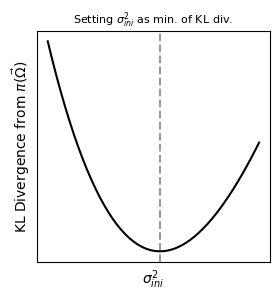

In [19]:
#Plotting a graph to make sure that the optimization results make sense, i.e. 'mean_var' lies at the minimum point.

variance_vec = np.linspace(10,13,50)

kl_list = []
for var in variance_vec:
  kl_list.append(kl_divergence_f(var, resi_sum_array, r_prior, D_prior, 0))

plt.figure(figsize=(3,3))
ax = plt.gca()
plt.plot(variance_vec, kl_list, 'k')
plt.axvline(mean_var, color='k', linestyle='--', alpha = 0.4)
plt.xlabel(r"$\sigma^2_{ini}$")
plt.title(r'Setting $\sigma^2_{ini}$ as min. of KL div.',fontsize = 8)
ax.set_xticks([])
ax.set_yticks([])
plt.ylabel(r"KL Divergence from $\pi(\vec{\Omega}$)")


In [20]:
# Minimizing KL divergence between the minimal parameter prior and initial likelihood to determine minimum $\sigma^2_R$ (eqn. 15)

l_r_std = r_vals[2] - r_vals[1]
l_r_prior = (1/np.sqrt(2*3.14*l_r_std**2))*np.exp(-1*(1/(2*l_r_std**2))*(r_vals - r_prior_mean)**2)

l_D_std = D_vals[2] - D_vals[1]
l_D_prior = (1/np.sqrt(2*3.14*l_D_std**2))*np.exp(-1*(1/(2*l_D_std**2))*(D_vals - D_prior_mean)**2)

def l_objective(variance_array):
    vari = variance_array[0]
    return kl_divergence_f(vari, resi_sum_array, l_r_prior, l_D_prior, np.finfo(float).tiny)

optimal_beta = minimize(l_objective, x0=[0.1], bounds=[(0.01, None)], method = 'Powell')

print(f"Optimal beta: {optimal_beta.x[0]:.4e}")

min_var = optimal_beta.x[0]

Optimal beta: 3.0169e-02


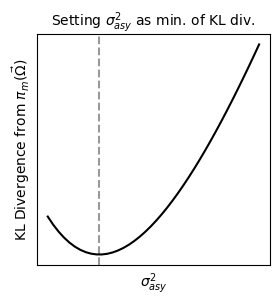

In [22]:
#Plotting a graph to make sure that the optimization results make sense, i.e. 'min_var' lies at the minimum point.

variance_vec = np.linspace(0.027,0.04,40)
kl_list = []
for var in variance_vec:
  kl_list.append(kl_divergence_f(var, resi_sum_array, l_r_prior, l_D_prior, np.finfo(float).tiny))

plt.figure(figsize=(3,3))
ax = plt.gca()
plt.plot(variance_vec, kl_list, 'k')
plt.axvline(min_var, color='k', linestyle='--', alpha = 0.4)
plt.xlabel(r"$\sigma^2_{asy}$")
ax.set_xticks([])
ax.set_yticks([])
plt.ylabel(r"KL Divergence from $\pi_m(\vec{\Omega}$)")
plt.title(r'Setting $\sigma^2_{asy}$ as min. of KL div.',fontsize = 10)
plt.show()

In [23]:
# Solving for the prior of sigma_R using mean_var and min_var
# Obtaining alpha_r, beta_r from solving (14) and (16).

print(f'Mean_var: {mean_var:.3f}, Min_var: {min_var:.3f}')
eps_s = 2*min_var/(mean_var - min_var)
alpha_r = 1 + eps_s
beta_r = eps_s*mean_var
print(f'Alpha_s: {alpha_r:.3f}, Beta_s: {beta_r:.3f}')

Mean_var: 11.593, Min_var: 0.030
Alpha_s: 1.005, Beta_s: 0.060


In [24]:
# Saving parameters of the two priors $\pi(\Omega)$ and $\pi(\sigma^2_R)$
Intermediate_Phase_Dict = {}
Intermediate_Phase_Dict['r_prior_mean'] = r_prior_mean
Intermediate_Phase_Dict['D_prior_mean'] = D_prior_mean
Intermediate_Phase_Dict['r_std'] = r_std
Intermediate_Phase_Dict['D_std'] = D_std
Intermediate_Phase_Dict['mean_var'] = mean_var
Intermediate_Phase_Dict['min_var'] = min_var
Intermediate_Phase_Dict['alpha_r'] = alpha_r
Intermediate_Phase_Dict['beta_r'] = beta_r

#torch.save(Intermediate_Phase_Dict, f'{MODEL_DIR}/Fisher_Intermediate_Phase_Dict.pth')

### 2nd training phase: with the complete loss function

#### Initializing

In [25]:
Intermediate_Phase_Dict = torch.load(f'{MODEL_DIR}/Fisher_Intermediate_Phase_Dict.pth', weights_only = False)

In [ ]:
torch.manual_seed(137)
lr = 3e-4

r_initial = Intermediate_Phase_Dict['r_prior_mean']
D_initial = Intermediate_Phase_Dict['D_prior_mean']
r_std = Intermediate_Phase_Dict['r_std']
D_std = Intermediate_Phase_Dict['D_std']

mean_var = Intermediate_Phase_Dict['mean_var']
s_initial = torch.tensor(mean_var)
alpha_r = Intermediate_Phase_Dict['alpha_r']
beta_r = Intermediate_Phase_Dict['beta_r']

nn_I = FCN(2,16,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/ini_epinn_fisher.pth'))

#Defining various lists to collect various loss and parameter values
loss_list = []
data_loss_list = []
pde_loss_list = []
s_list = []
r_list = []
D_list = []
#The trainable parameters: r, D and $\sigma^2_R$
r_m = torch.nn.Parameter(torch.tensor(r_initial, device=device, requires_grad=True))
D_m = torch.nn.Parameter(torch.tensor(D_initial, device=device, requires_grad=True))
s = torch.nn.Parameter(torch.tensor(s_initial, device=device, requires_grad=True))

optimizer = optim.Adam([r_m, D_m, s] + list(nn_I.parameters()), lr=lr)

#### Model training

In [ ]:
n_D = XT.shape[0]

for epoch in range(300_001):

    optimizer.zero_grad()

    #-----PDE Residual Loss----------------------------------
    L_p_alpha, L_p_beta, L_p_nu, L_pred = nn_I(torch.cat((x_residual, t_residual), dim=1))
    dL_dx = torch.autograd.grad(L_pred, x_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
    grad2_dL_dx = torch.autograd.grad(dL_dx, x_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
    dL_dt = torch.autograd.grad(L_pred, t_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]

    mse_physics_loss = torch.sum((-dL_dt + D_m*grad2_dL_dx + r_m*L_pred*(1-L_pred))**2)

    physics_loss = 0.5*(1/s)*mse_physics_loss
    physics_prior_loss = (alpha_r + 2/2)*torch.log(s) + beta_r/s

    #-----Data Loss------------------------------------------

    data_loss = n_D*evidential_data_loss(L_pred, U_flat, L_p_nu, L_p_alpha, L_p_beta)

    #-----Prior Loss-----------------------------------------
    neg_ll_r_prior = (1/(2*torch.tensor(r_std)**2))*((r_m - torch.tensor(r_prior_mean))**2)
    neg_ll_D_prior = (1/(2*torch.tensor(D_std)**2))*((D_m - torch.tensor(D_prior_mean))**2)

    #-----Total loss-----------------------------------------
    loss = data_loss + physics_loss + physics_prior_loss + neg_ll_r_prior + neg_ll_D_prior

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}, data: {data_loss.item():.5e}, PDE_L: {physics_loss.item():.5e} ")
        print(f"r_m : {r_m.item():.4e}, D: {D_m.item():.4e}, s:{s.item():.4e}")
        loss_list.append(loss.item())
        data_loss_list.append(data_loss.item())
        pde_loss_list.append(physics_loss.item())
        r_list.append(r_m.item())
        D_list.append(D_m.item())
        s_list.append(s.item())

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))
axes[0, 0].plot(loss_list, label='Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 1].plot(data_loss_list, label='Data Loss', color='orange')
axes[0, 1].set_title('Data Loss')
axes[0, 2].plot(pde_loss_list, label='PDE Loss', color='green')
axes[0, 2].set_title('PDE Loss')
axes[1, 0].plot(r_list, label='r_m', color='blue')
axes[1, 0].set_title('r_m')
axes[1, 1].plot(D_list, label='D_m', color='orange')
axes[1, 1].set_title('D_m')
axes[1, 2].plot(s_list, label='s', color='green')
axes[1, 2].set_title('s')

plt.tight_layout()

In [ ]:
torch.save(nn_I.state_dict(), f'{MODEL_DIR}/final_epinn_fisher.pth')
torch.save({
    'loss_list': loss_list,
    'data_loss_list': data_loss_list,
    'pde_loss_list': pde_loss_list,
    'r_list': r_list,
    'D_list': D_list,
    's_list': s_list
}, f'{MODEL_DIR}/final_epinn_fisher_loss.pth')

### Analysis of results

#### Loading model and visualizing its prediction

In [30]:
#Loading the saved final model
nn_I = FCN(2,16,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/final_epinn_fisher.pth'))

checkpoint = torch.load(f'{MODEL_DIR}/final_epinn_fisher_loss.pth')
s_list = checkpoint['s_list']

# Saving parameters of the two priors $\pi(\Omega)$ and $\pi(\sigma^2_R)$
Intermediate_Phase_Dict = torch.load(f'{MODEL_DIR}/Fisher_Intermediate_Phase_Dict.pth', weights_only = False)
r_prior_mean = Intermediate_Phase_Dict['r_prior_mean']
D_prior_mean = Intermediate_Phase_Dict['D_prior_mean']
r_std = Intermediate_Phase_Dict['r_std']
D_std = Intermediate_Phase_Dict['D_std']


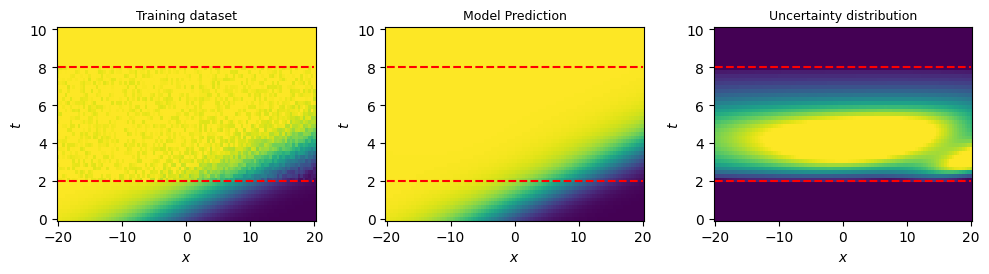

In [31]:
#Visualizing model prediction
Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(XT)

n_L_pred = np.squeeze(L_pred.detach().cpu().numpy())
n_Lp_alpha = np.squeeze(Lp_alpha.detach().cpu().numpy())
n_Lp_beta = np.squeeze(Lp_beta.detach().cpu().numpy())
n_Lp_nu = np.squeeze(Lp_nu.detach().cpu().numpy())

plot_L_pred = n_L_pred.reshape(50, 100)
plot_Lp_alpha = n_Lp_alpha.reshape(50, 100)
plot_Lp_beta = n_Lp_beta.reshape(50, 100)
plot_Lp_nu = n_Lp_nu.reshape(50, 100)

uncertainty = (1+ 1/plot_Lp_nu)*plot_Lp_beta/(plot_Lp_alpha-1)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
x = np.linspace(-20, 20, 100)
t = np.linspace(0, 10, 50)
X, T = np.meshgrid(x, t)
pc = axes[0].pcolormesh(X, T, U_reconstructed.detach().cpu().numpy(), shading='auto', cmap='viridis', vmin=0, vmax=1)

axes[0].set_title(r"Training dataset", fontsize=9)
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$t$")
axes[0].plot([-20,20],[2,2],'r--')
axes[0].plot([-20,20],[8,8],'r--')

pc = axes[1].pcolormesh(X, T, plot_L_pred, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[1].set_title(r"Model Prediction", fontsize=9)
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$t$")
axes[1].plot([-20,20],[2,2],'r--')
axes[1].plot([-20,20],[8,8],'r--')


pc = axes[2].pcolormesh(X, T,uncertainty.reshape(50,100), shading='auto', cmap='viridis', vmin=0, vmax=0.01)
axes[2].set_title(r"Uncertainty distribution", fontsize=9)
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$t$")
axes[2].plot([-20,20],[2,2],'r--')
axes[2].plot([-20,20],[8,8],'r--')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### ECP plot, noise-uncertainty correlation

In [32]:
uncertainty_avg = np.mean(uncertainty, axis = -1)
noise_avg = np.mean(np.abs(noise), axis = -1)
corr, pval = spearmanr(np.abs(noise).flatten(), uncertainty.flatten())
print("Spearman correlation:", corr)
print("p-value:", pval)

Spearman correlation: 0.7463517268601975
p-value: 0.0


Text(0.5, 1.0, 'Error Calibration Plot')

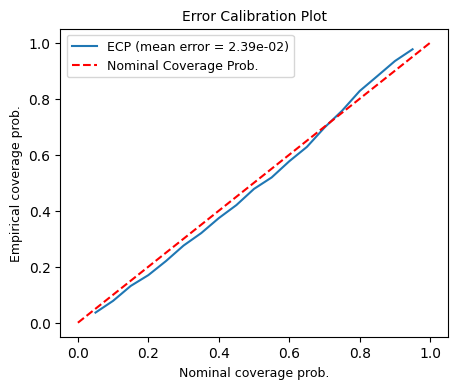

In [33]:
#Empirical coverage probability

empirical_data = np.squeeze(U_flat).detach().cpu().numpy()

ecp_list = []
dis_list = []

for j in range(19):

  interval_CI = (j+1)*0.05

  neg_CI_delta = CI_calculation(interval_CI, n_Lp_alpha, n_Lp_beta ,
                                  n_Lp_nu, n_L_pred)

  acc=0
  for i in range(len(empirical_data)):
    if  np.abs(empirical_data[i] - n_L_pred[i])  < np.abs(neg_CI_delta[i]) :
      acc += 1

  empirical_ecp = acc/len(empirical_data)
  discrepancy = np.abs(empirical_ecp - interval_CI)

  dis_list.append(discrepancy)
  ecp_list.append(acc/len(empirical_data))

plt.figure(figsize=(5,4))
plt.plot(np.arange(0.05, 1.00, 0.05), np.array(ecp_list), label=f'ECP (mean error = {np.mean(dis_list):.2e})')
plt.plot([0,1],[0,1],'r--', label='Nominal Coverage Prob.')
plt.legend(fontsize = 9)
plt.xlabel('Nominal coverage prob.', fontsize=9)
plt.ylabel('Empirical coverage prob.', fontsize = 9)
plt.title('Error Calibration Plot', fontsize=10)


#### Computing posterior

In [34]:
# Parameter domains
r_vals = np.linspace(0.1, 2.0, 50)
D_vals = np.linspace(0.5, 10, 50)

# Final $\sigma^2_R$ value defining the likelihood function
s_mode = s_list[-1]

# Prior distributions for the parameters
r_prior = (1/np.sqrt(2*3.14*r_std**2))*np.exp(-1*(1/(2*r_std**2))*(r_vals - r_prior_mean)**2)
D_prior = (1/np.sqrt(2*3.14*D_std**2))*np.exp(-1*(1/(2*D_std**2))*(D_vals - D_prior_mean)**2)

In [35]:
L_p_alpha, L_p_beta, L_p_nu, L_pred = nn_I(torch.cat((x_residual, t_residual), dim=1))
dL_dx = torch.autograd.grad(L_pred, x_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
grad2_dL_dx = torch.autograd.grad(dL_dx, x_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
dL_dt = torch.autograd.grad(L_pred, t_residual, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]

n_L_pred = np.squeeze(L_pred.detach().cpu().numpy())
n_Lp_alpha = np.squeeze(L_p_alpha.detach().cpu().numpy())
n_Lp_beta = np.squeeze(L_p_beta.detach().cpu().numpy())
n_Lp_nu = np.squeeze(L_p_nu.detach().cpu().numpy())

njit_grad2x_L = np.squeeze(grad2_dL_dx.detach().cpu().numpy())
njit_dL_dt = np.squeeze(dL_dt.detach().cpu().numpy())
resi_sum = compute_z_array(r_vals, D_vals, n_L_pred, njit_grad2x_L, njit_dL_dt )
resi_sum_array = np.sum(resi_sum, axis = -1)
obj = njit_marginal_ll(s_mode, resi_sum_array)

@njit
def posterior_array(obj, r_prior, D_prior):
  posterior_init = np.empty((len(r_vals), len(D_vals)))
  for i in range(len(r_vals)):
    for j in range(len(D_vals)):
          posterior_init[i,j] = obj[i,j]*r_prior[i]*D_prior[j]
  return posterior_init

posterior_dis = posterior_array(obj, r_prior, D_prior)

In [36]:
posterior_norm = posterior_dis / np.sum(posterior_dis)
r_marginal = np.sum(posterior_norm, axis=(1))
r_mean = np.sum(r_vals * r_marginal)
D_marginal = np.sum(posterior_norm, axis=(0))
D_mean = np.sum(D_vals * D_marginal)

# Flatten posterior and normalize
posterior_flat = posterior_norm.ravel()
grid_shape = posterior_dis.shape

n_samples = 100_000
flat_indices = np.random.choice(len(posterior_flat), size=n_samples, p=posterior_flat)
multi_indices = np.array(np.unravel_index(flat_indices, grid_shape)).T

r_samples = r_vals[multi_indices[:, 0]]
D_samples = D_vals[multi_indices[:, 1]]

ci68 = lambda x: (np.percentile(x, 16), np.percentile(x, 84))

r_ci68 = ci68(r_samples)
D_ci68 = ci68(D_samples)

median_r = np.mean(r_samples)
median_D = np.mean(D_samples)

In [37]:
r68 = np.array(r_ci68)
d68 = np.array(D_ci68)
print(f"Best-fit value and 68% C.I for r: {median_r:.3f} with C.I. ({r68[0]:.3f}, {r68[1]:.3f})")
print(f"Best-fit value and 68% C.I for D: {median_D:.3f} with C.I. ({d68[0]:.3f}, {d68[1]:.3f})")

Best-fit value and 68% C.I for r: 1.600 with C.I. (1.573, 1.651)
Best-fit value and 68% C.I for D: 6.261 with C.I. (4.959, 7.480)


In [38]:
p_samples = 20_000

samples = np.column_stack([r_samples[:p_samples], D_samples[:p_samples]])

f_samples = np.zeros([p_samples, 50, 100])

for i in range(p_samples):
  s_r, s_D = samples[i]
  f_samples[i,:,:] = exact_wave(s_r, s_D)

L_monte_pred = n_L_pred.reshape(50, 100)
L_monte_pred.shape
mean_f_samples = np.mean(f_samples, axis=0)
T_C = np.sum((np.squeeze(L_monte_pred) - mean_f_samples)**2)
T_samples = np.zeros(20_000)

for i in range(20_000):
    T_samples[i] = np.sum((f_samples[i,:,:] - mean_f_samples)**2)

p_value = np.mean(T_samples >= T_C)

print(f"p-value indicating plausibility of model realizing prior distribution of parameters: {p_value}")

p-value indicating plausibility of model realizing prior distribution of parameters: 0.93455


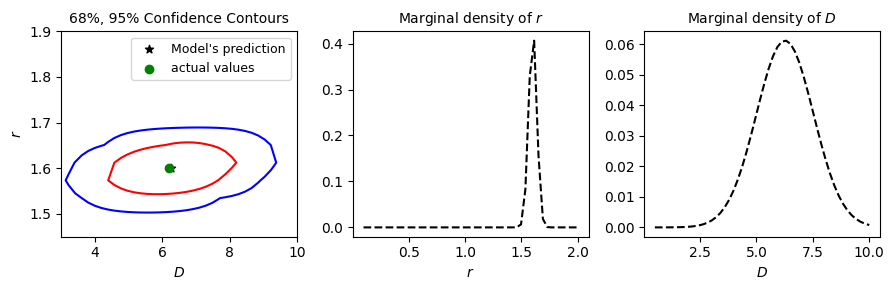

In [39]:
#Plotting posterior distributions and marginal distributions
X, Y = np.meshgrid(D_vals, r_vals)

sorted_post = np.sort(posterior_norm.ravel())[::-1]
cumulative = np.cumsum(sorted_post)

# Find contour levels
level_68 = sorted_post[np.searchsorted(cumulative, 0.68)]
level_95 = sorted_post[np.searchsorted(cumulative, 0.95)]


fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].contour(X, Y, posterior_norm, levels=[level_95, level_68], colors=['blue', 'red'])

axes[0].scatter(median_D, median_r, color='black', marker='*',
                label=f'Model\'s prediction')
axes[0].scatter(6.2, 1.6, color='green', marker='o', label='actual values')
axes[0].set_title(r'68%, 95% Confidence Contours', fontsize = 10)
axes[0].set_xlim(3, 10)
axes[0].set_ylim(1.45, 1.9)
axes[0].set_xlabel(r'$D$')
axes[0].set_ylabel(r'$r$')
axes[0].legend(fontsize=9)

axes[1].plot(r_vals, r_marginal, 'k--')
axes[1].set_xlabel(r'$r$')
axes[1].set_title('Marginal density of $r$', fontsize = 10)

axes[2].plot(D_vals, D_marginal, 'k--')
axes[2].set_xlabel(r'$D$')
axes[2].set_title('Marginal density of $D$', fontsize = 10)

plt.tight_layout()
